In [2]:
import sys 
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, top_k_accuracy_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product

from torch.utils.data import DataLoader, TensorDataset

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import VariationalAutoencoder, Autoencoder

In [3]:
df = pd.read_csv('../data/network_model_dataset_7200.csv', index_col=0)
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[[str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(round(df['beta'].min(), 2), 
                                                                  round(df['beta'].max(), 2),
                                                                  round(df['alpha'].min(), 2),
                                                                  round(df['alpha'].max(), 2)))

Диапазон параметров beta:[0.1, 0.99], alpha:[0.2, 0.99]


In [4]:
X_train, X_test, y_train, y_test =  train_test_split(data.drop(columns=['ts']), 
                                                     data.ts.values, 
                                                     test_size=0.2, 
                                                     random_state=42)
X_train, X_test = X_train.values, X_test.values

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Autoencoder

In [6]:
def loss(criterion, pred, gt):
    loss = criterion(pred, gt)
    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

In [7]:
def train(
    model,
    n_epochs,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    patience=5,
    delta=0,
    device='cpu'
):
    best_loss = float('inf')
    counter = 0
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            loss = criterion(pred, y_batch.to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation on test/validation set
        model.eval()
        test_total_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                pred_test = model(X_test.to(device))
                loss_test = criterion(pred_test, y_test.to(device))
                test_total_loss += loss_test.item()

        avg_test_loss = test_total_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}, Train loss: {avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")

        if avg_test_loss < 3300:
            break

        # Early stopping logic
        # if avg_train_loss < best_loss - delta:
        #     best_loss = avg_train_loss
        #     counter = 0
        # else:
        #     counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break
    return train_losses, test_losses


#### Grid search for best hiddens_size and latent_size

In [15]:
from itertools import product

mse_cr = F.mse_loss
r2_cr = r2_loss

# Define grid ranges
hidden_sizes = [16, 32, 64, 128, 256]               # Example values; adjust as needed
latent_sizes = [16, 32, 64, 128, 256]                 # Example values; adjust as needed

results = []

# for hidden_size, latent_size in product(hidden_sizes, latent_sizes):
#     print(f"Testing hidden_size={hidden_size}, latent_size={latent_size}")
    
#     # Initialize new model for each combo
#     model = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    
#     # You must re-create your DataLoader objects if your data depends on model params
#     # train_loader, test_loader = ...
  
#     # Train model
#     train_losses, test_losses = train(
#         model=model,
#         n_epochs=50,   # reduce for faster search, or keep as n_epochs
#         train_loader=train_loader,
#         test_loader=test_loader,
#         criterion=mse_cr,
#         optimizer=optimizer,
#         scheduler=None,      # or your scheduler if needed
#         patience=5,
#         delta=0,
#         device=device
#     )
#     # Evaluate performance (last test loss, or min/avg as you wish)
#     best_test_loss = min(test_losses)
#     results.append({
#         'hidden_size': hidden_size,
#         'latent_size': latent_size,
#         'test_loss': best_test_loss
#     })

# # Find best combination
# best_config = min(results, key=lambda x: x['test_loss'])
# print("Best config:", best_config)

# # To display all results
# for res in results:
#     print(res)

#### AE train

In [7]:
hidden_size = 256
latent_size = 32
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
ae = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=5e-4)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [8]:
train_losses, test_losses = train(model=ae,
        n_epochs=100,   # reduce for faster search, or keep as n_epochs
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=mse_cr,
        optimizer=optimizer,
        scheduler=None,      # or your scheduler if needed
        patience=5,
        delta=0,
        device=device)

Epoch 1, Train loss: 319226.0585, Test loss: 176655.8842
Epoch 2, Train loss: 86757.0707, Test loss: 49748.6644
Epoch 3, Train loss: 47244.6071, Test loss: 40136.8204
Epoch 4, Train loss: 34927.8840, Test loss: 35197.3918
Epoch 5, Train loss: 25107.9198, Test loss: 24563.4783
Epoch 6, Train loss: 19387.7584, Test loss: 17355.1864
Epoch 7, Train loss: 16157.3109, Test loss: 12403.2876
Epoch 8, Train loss: 14599.3716, Test loss: 18348.9259
Epoch 9, Train loss: 11620.9201, Test loss: 10167.8707
Epoch 10, Train loss: 9876.9815, Test loss: 12676.7892
Epoch 11, Train loss: 9676.0539, Test loss: 6362.3290
Epoch 12, Train loss: 7811.0793, Test loss: 9350.6237
Epoch 13, Train loss: 7455.7284, Test loss: 6098.9733
Epoch 14, Train loss: 6867.3554, Test loss: 5727.9867
Epoch 15, Train loss: 7069.3876, Test loss: 9031.6375
Epoch 16, Train loss: 6644.5667, Test loss: 5908.5066
Epoch 17, Train loss: 5992.2922, Test loss: 13055.0270
Epoch 18, Train loss: 6551.5656, Test loss: 6264.8064
Epoch 19, Train

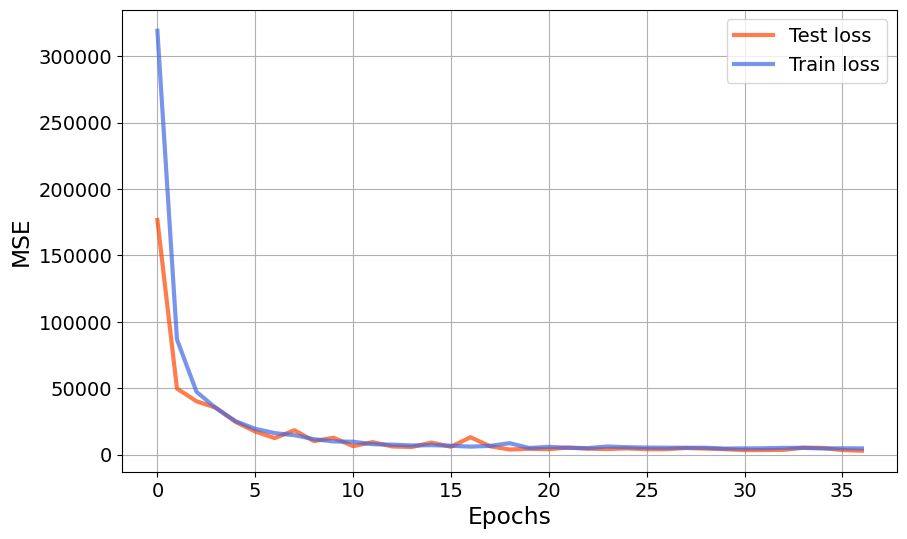

In [55]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_losses, lw=3, label='Test loss', color='OrangeRed', alpha=0.7)
ax.plot(train_losses, lw=3, label='Train loss', color='RoyalBlue', alpha=0.7)
ax.set_xlabel('Epochs', fontsize=1.2*fontsize)
ax.set_ylabel('MSE', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid()
fig.savefig('../figures/ae_loss_epochs.png', dpi=600, bbox_inches='tight')
fig.savefig('../figures/ae_loss_epochs.pdf', bbox_inches='tight')


In [10]:
test(ae, X_test, y_test)

R2 Score: 0.8507035425139798


In [9]:
# Saving
# torch.save(ae, '../models/autoencoder.pt')

# Loading
ae = torch.load('../models/autoencoder.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=150, bias=True)
  )
)

In [39]:
batch = next(iter(train_loader))
print(batch[0].size())
yhat = model(batch[0])

torch.Size([16, 2])


#### AE Colormap

In [13]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

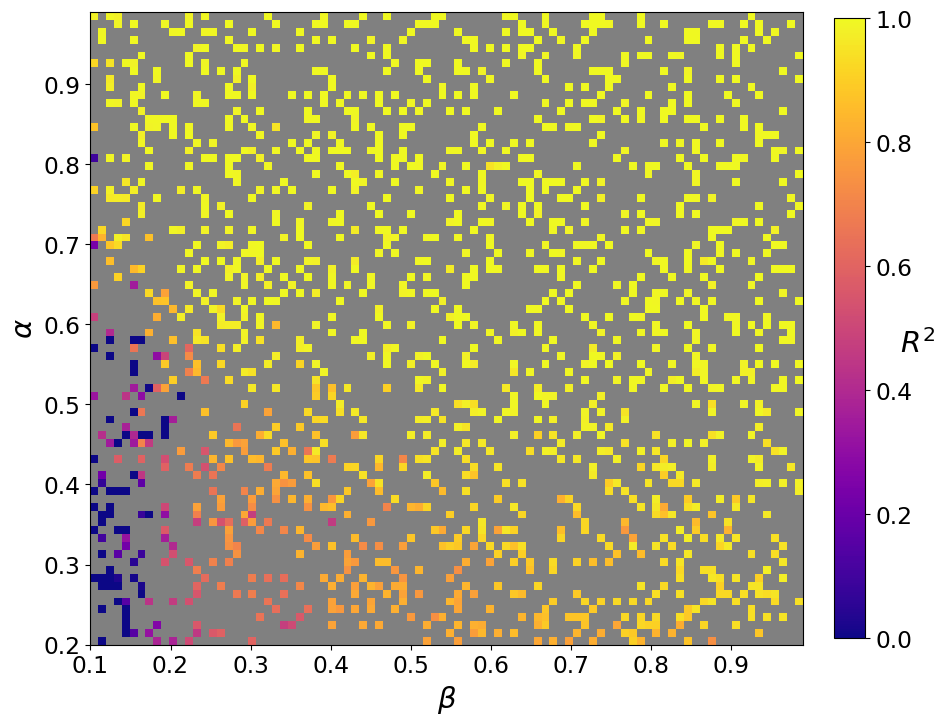

In [76]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x

# Get plasma colormap and create nonlinear version
plasma = plt.cm.plasma
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
nonlinear_cmap.set_bad('gray')  # train in gray
img = ax.imshow(masked_heatmap, origin='lower', cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]],
                 aspect='equal')
cbar = fig.colorbar(img, ax=ax, label='$R^2$', fraction=0.04, pad=0.04)
cbar.ax.yaxis.label.set_size(1.5*fontsize)  # colorbar label fontsize
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.tick_params(labelsize=1.2*fontsize)    # colorbar tick labels fontsize
ax.set_xlabel(r'$\beta$', fontsize=1.5*fontsize)
ax.set_ylabel(r'$\alpha$', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=1.2*fontsize)
# ax.set_title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
fig.savefig('../figures/ae_colormap_point_estimation.png', dpi=600, bbox_inches='tight')
fig.savefig('../figures/ae_colormap_point_estimation.pdf', bbox_inches='tight')

In [12]:
batch = next(iter(train_loader))
print(batch[0].size())
yhat = ae(batch[0])

torch.Size([16, 2])


In [34]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    # ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.set_ylim(0, 1500)
    ax.set_xlim(-5, 150)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

In [36]:
for _ in range(len(y_test)):
    index = random.randint(0, len(y_test))
    index = _
    if abs(X_test[index][0] - 0.7) < 0.1 and \
        abs(X_test[index][1] - 0.8) < 0.1 and max(y_test[index]) < 1500:
        fig = plot_test(X_test[index], y_test[index])
        fig.savefig(r'../figures/simulation_{}.png'.format(index), 
                    dpi=600, bbox_inches='tight')
        # fig.savefig(r'../figures/ae_simulation_{}.pdf'.format(index), 
        #             bbox_inches='tight')
        print(X_test[index])
        print(index)
        break

[0.18 0.22]
[0.46 0.39]
[0.58 0.6 ]


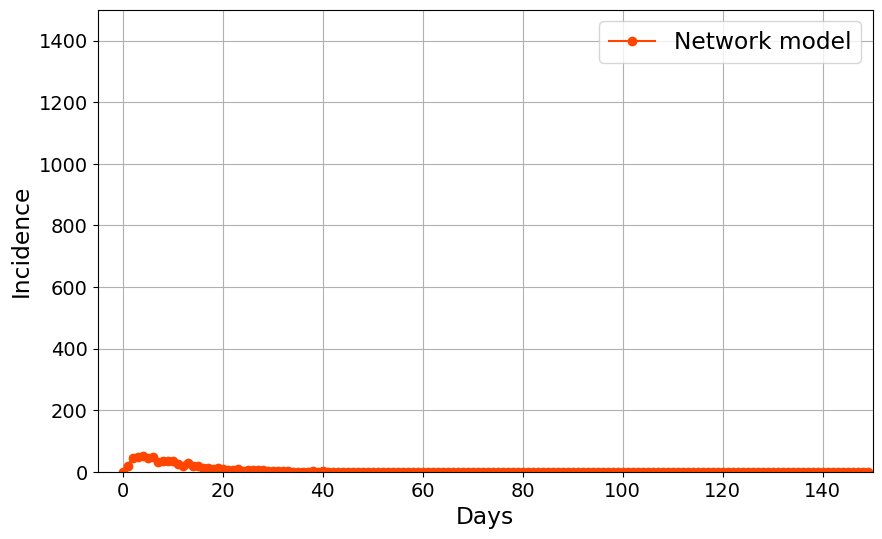

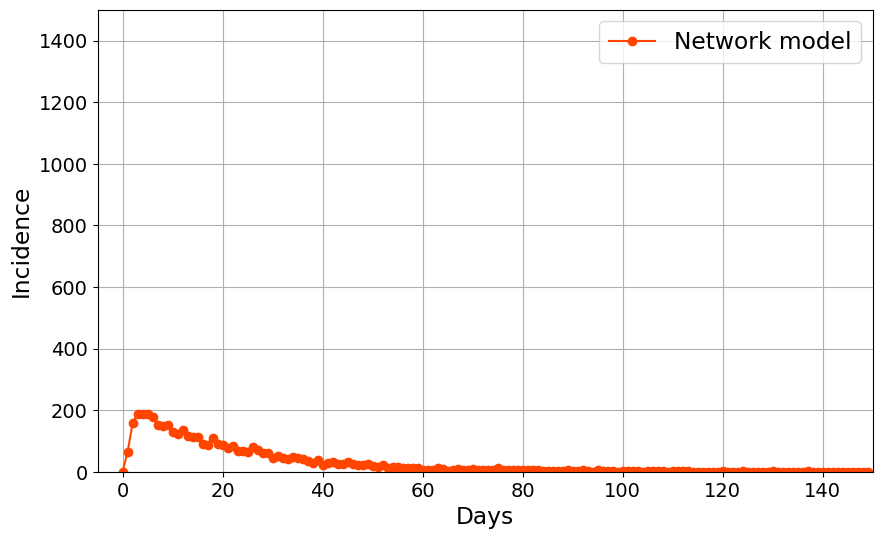

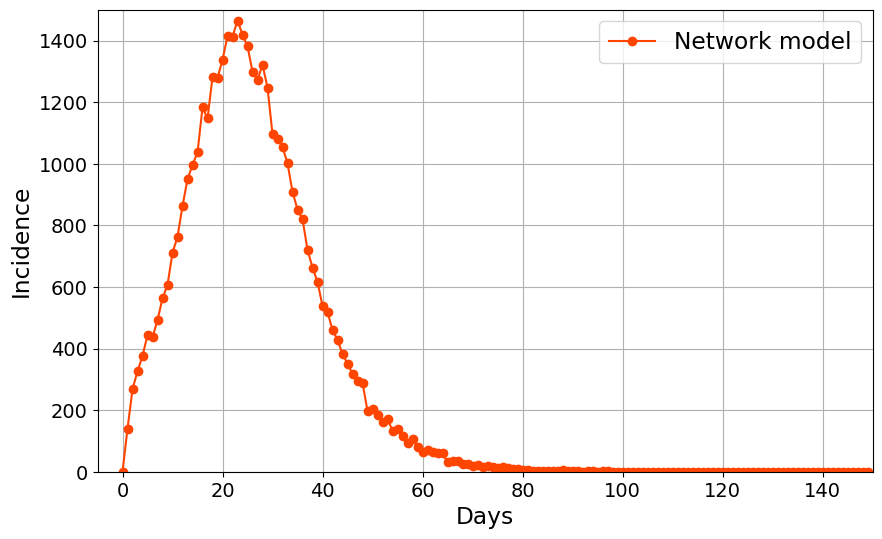

In [39]:
for index in [26, 19, 511]:
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'../figures/network_only_simulation_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')
    fig.savefig(r'../figures/network_only_simulation_{}.pdf'.format(index), 
                bbox_inches='tight')
    print(X_test[index])

### Variational autoencoder

In [23]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

def warmup_loss(epoch, n_epochs, criterion, steps, pred, mu, logvar, gt, use=True):
    if use:
        if epoch/n_epochs < steps:
            loss = criterion(pred ,gt)
        else:
            mse_loss = criterion(pred, gt)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse_loss + kl_loss
    else:
        loss = criterion(pred, gt)

    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred, _, _ = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    tb = SummaryWriter()

    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred, mu, logvar = model(X_batch.to(device))

            loss = warmup_loss(epoch, n_epochs, criterion, 0, pred, mu, logvar, y_batch.to(device), use=True)

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        tb.add_scalar("Total loss", loss.item(), epoch)
    tb.close()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
hidden_size = 512
latent_size = 256
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
vae = VariationalAutoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=5e-4)

In [27]:
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [28]:
train(vae, n_epochs, train_loader, mse_cr, optimizer, lr_sched)

100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


In [29]:
test(vae, X_test, y_test)

R2 Score: 0.8851743287560514


In [30]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(vae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

/var/folders/z9/3mmkvbxj1g5gk4qrms1dj77h0000gn/T/ipykernel_61708/350738424.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


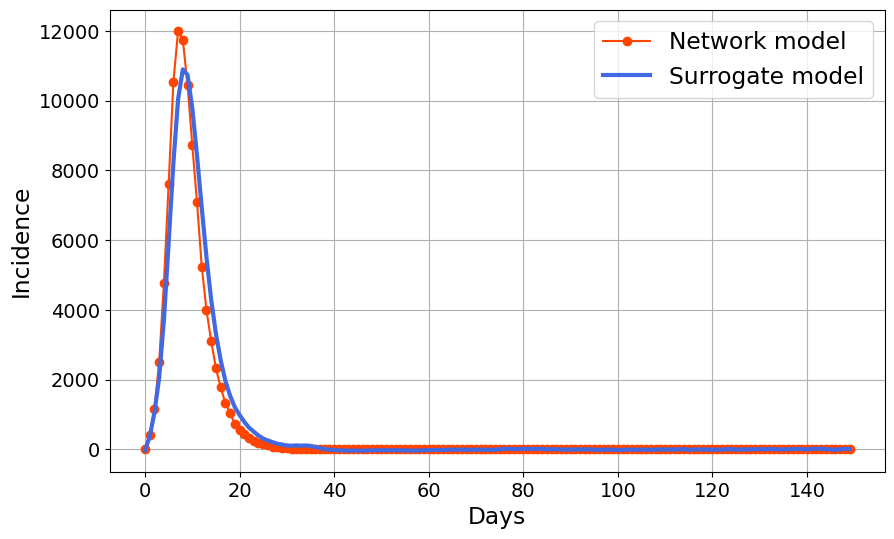

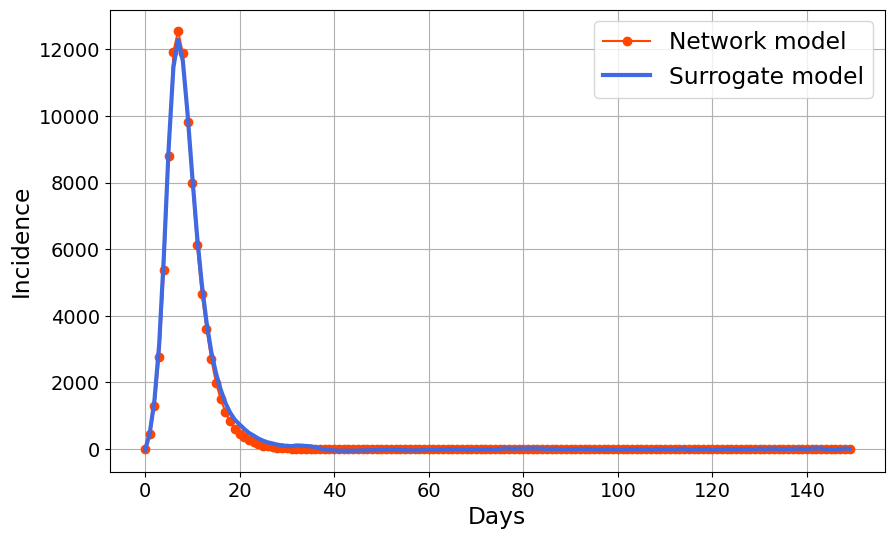

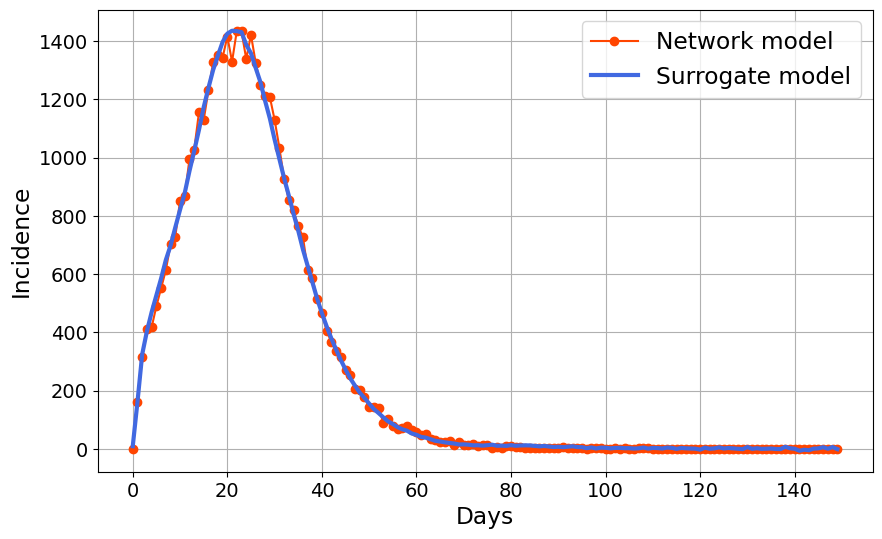

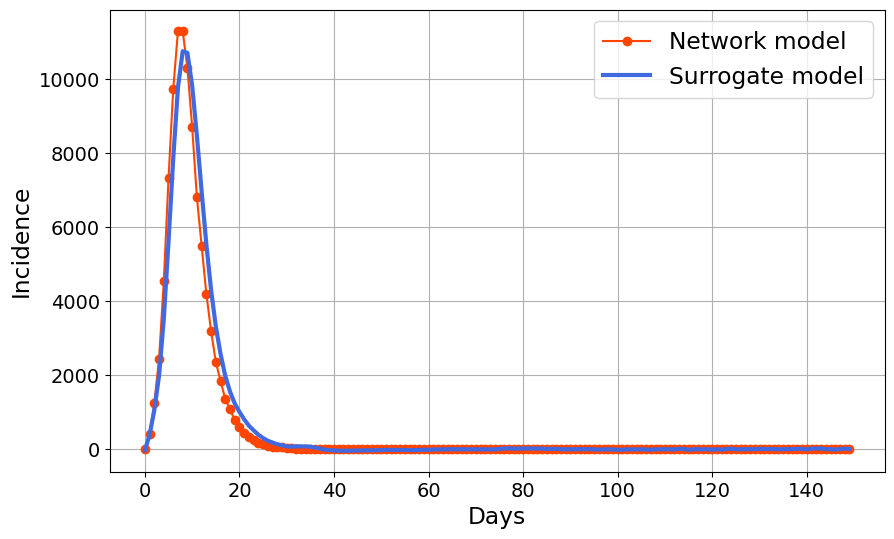

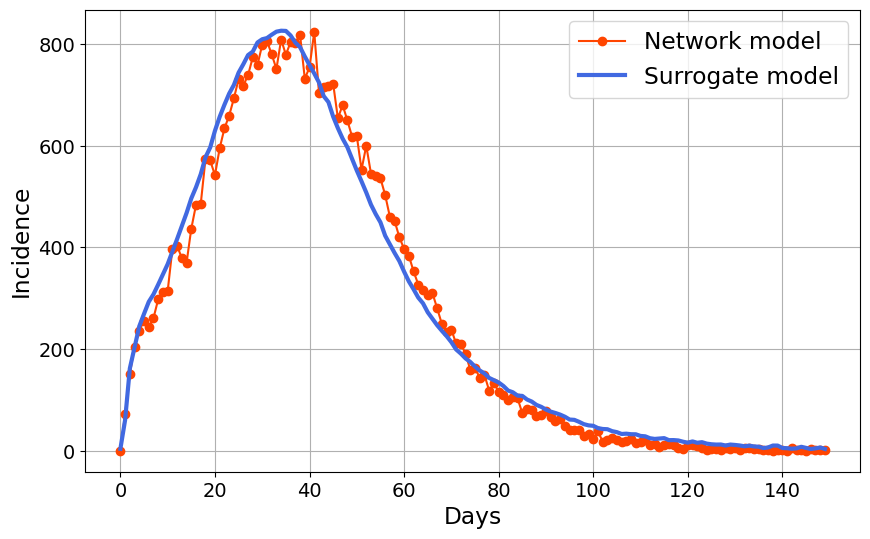

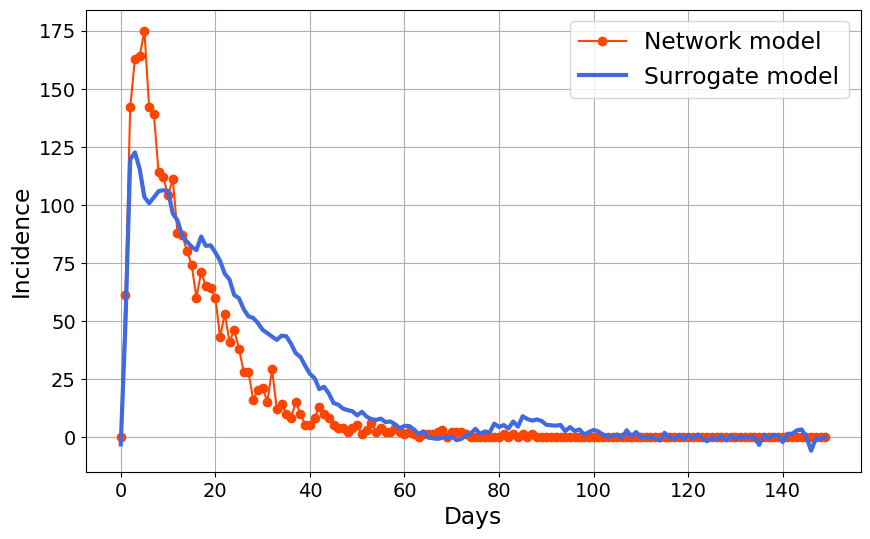

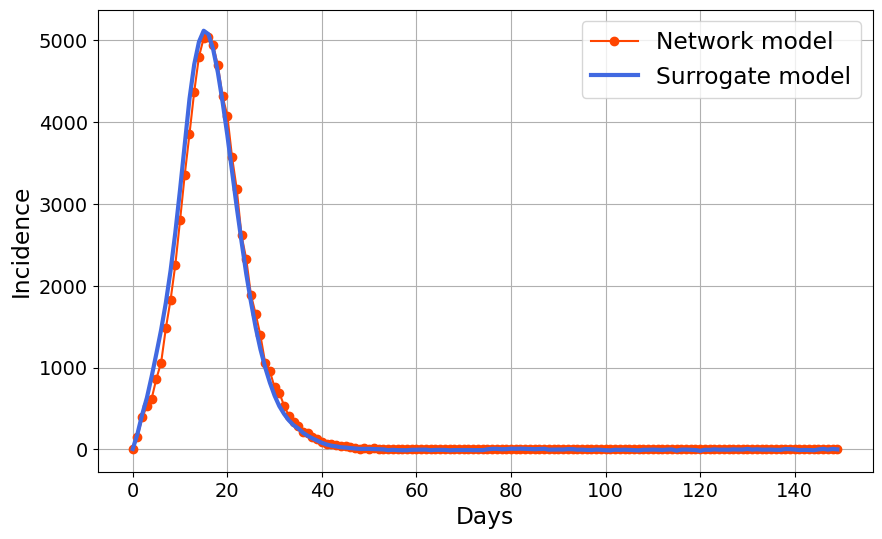

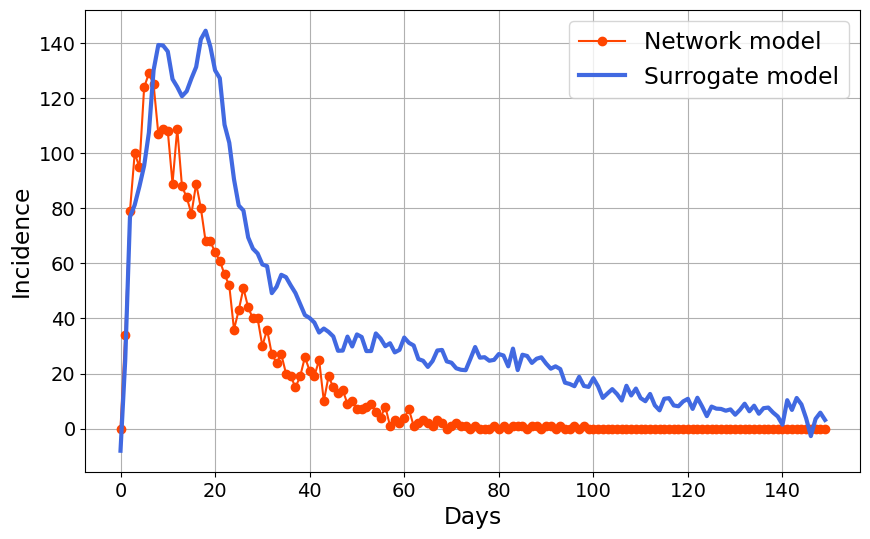

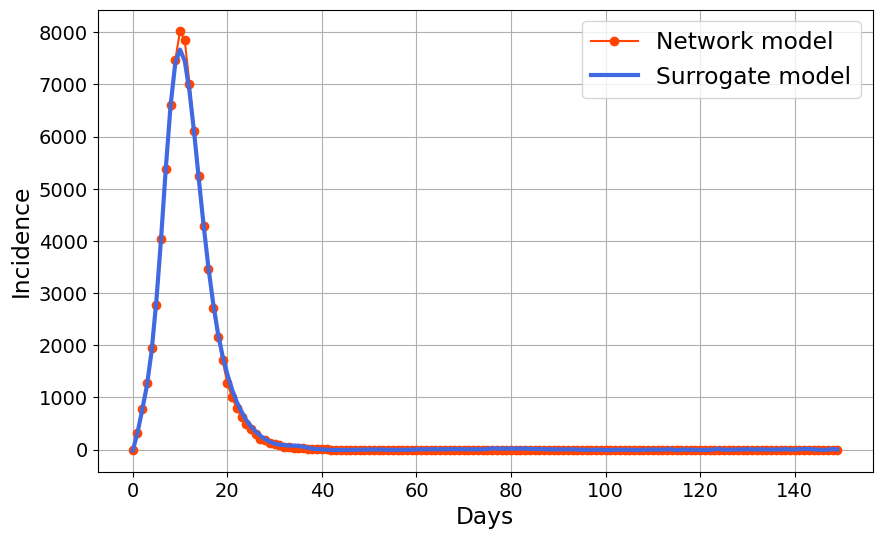

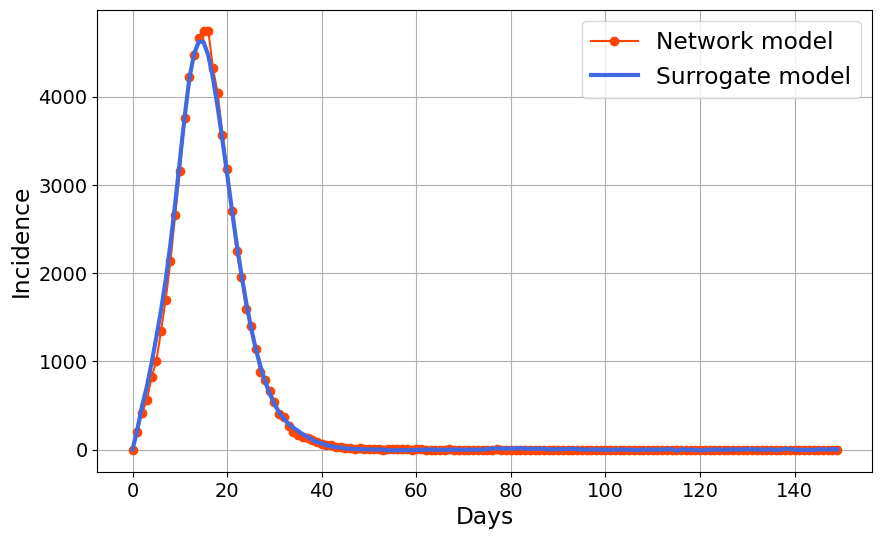

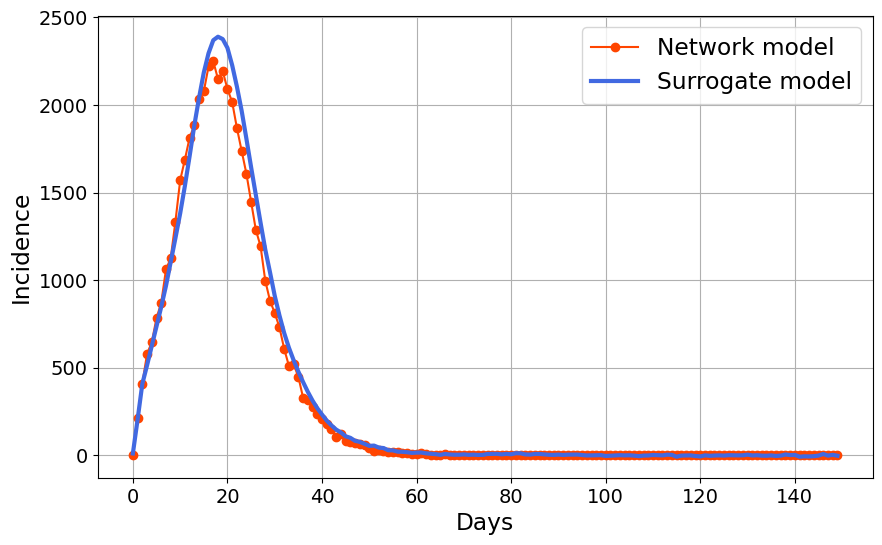

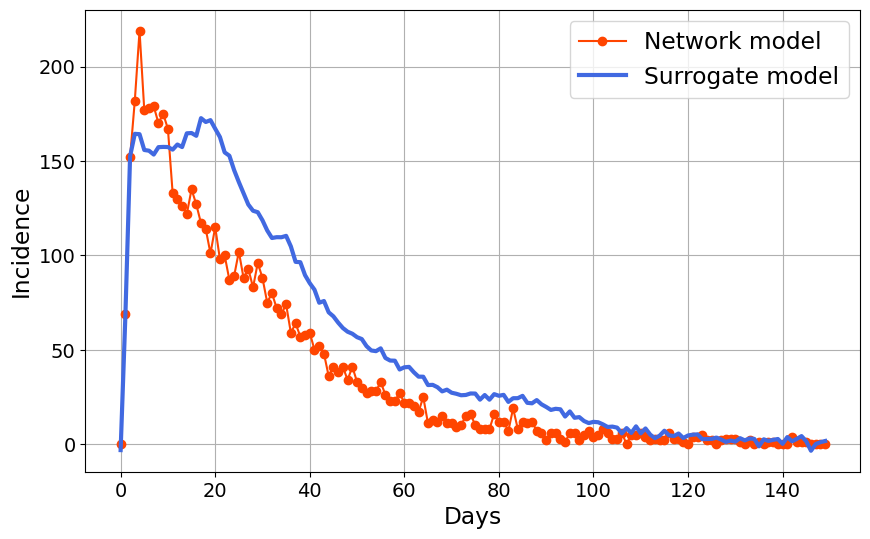

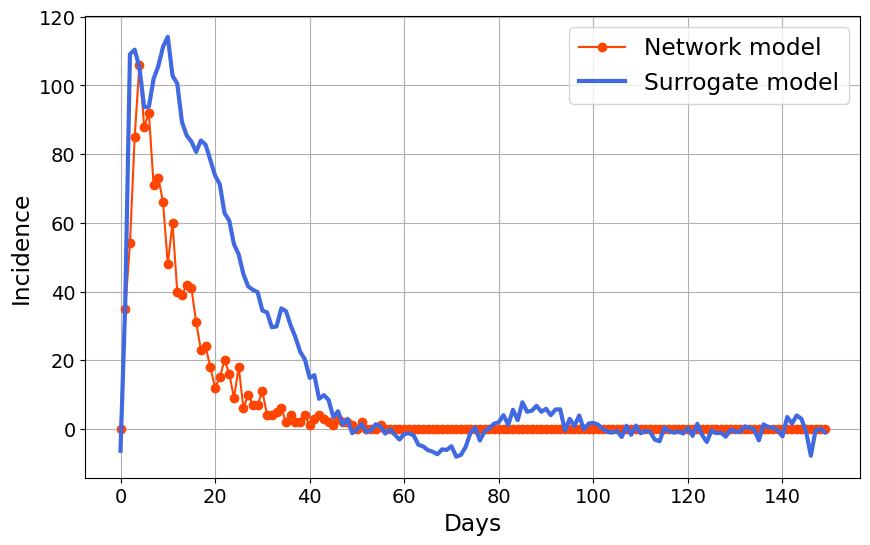

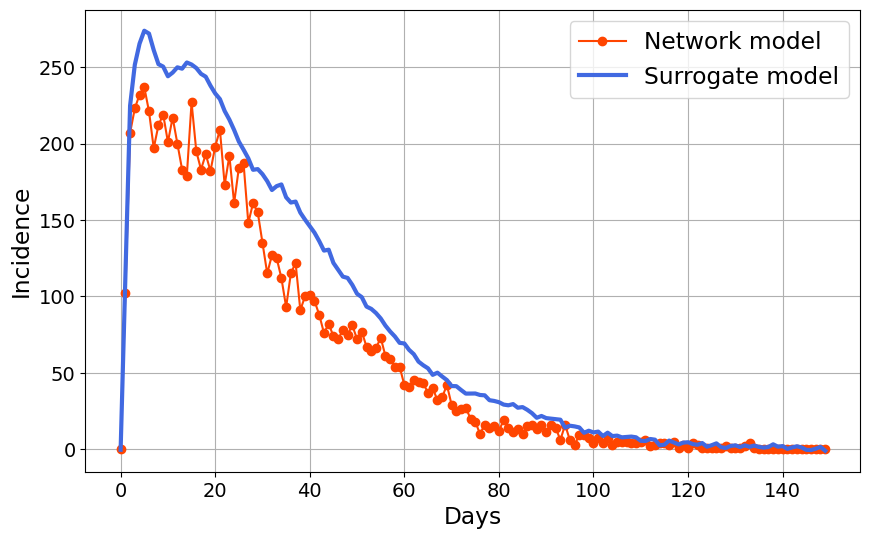

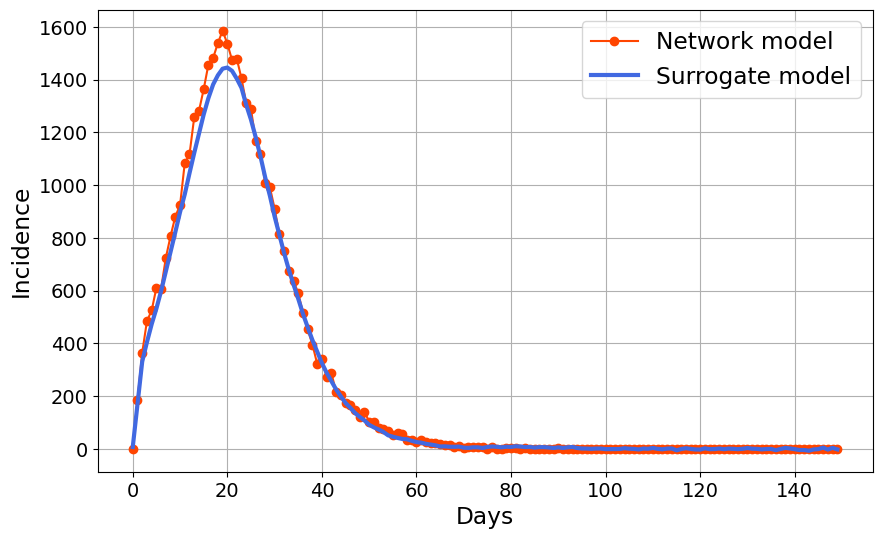

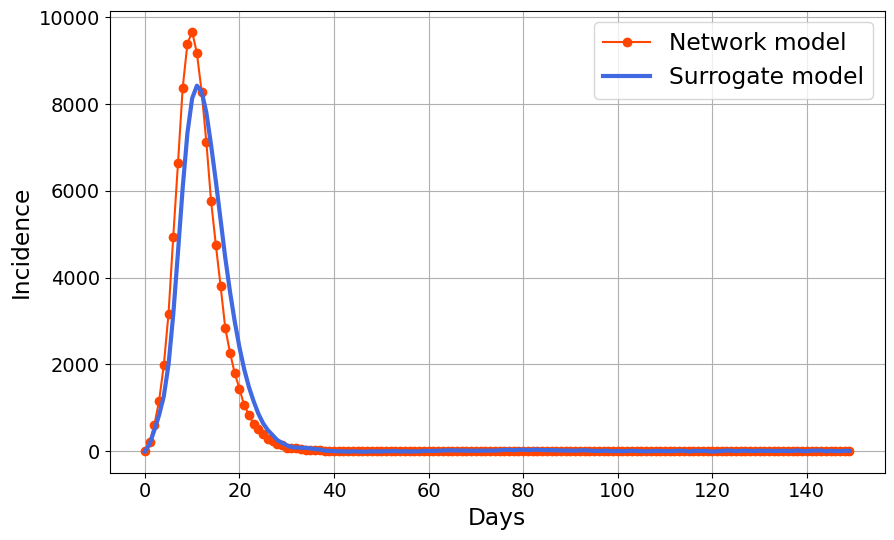

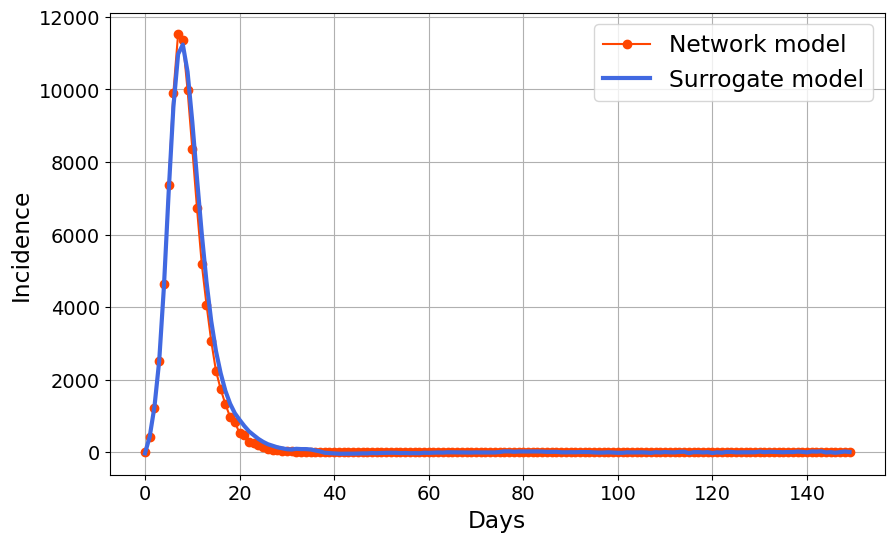

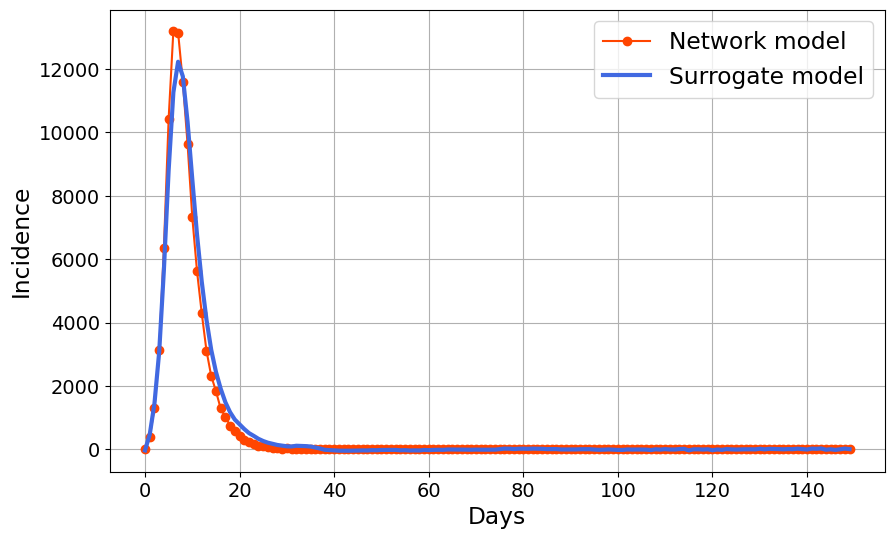

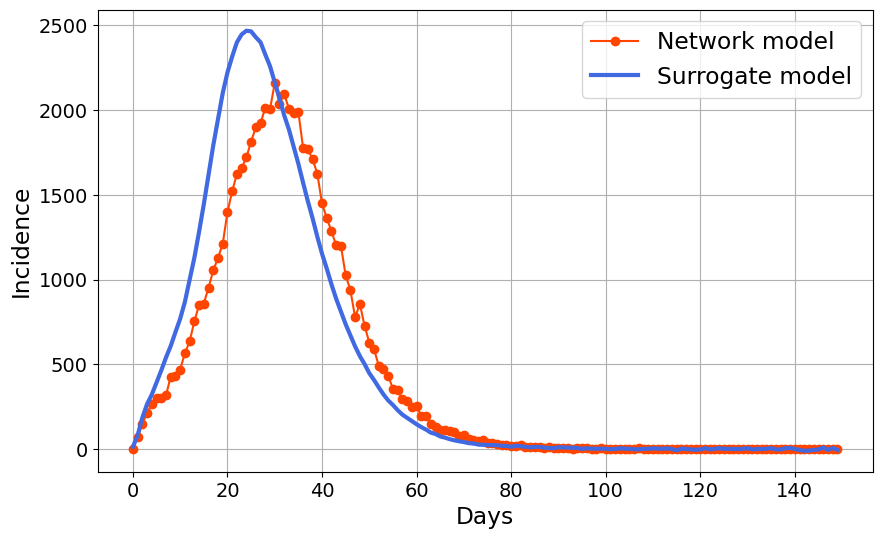

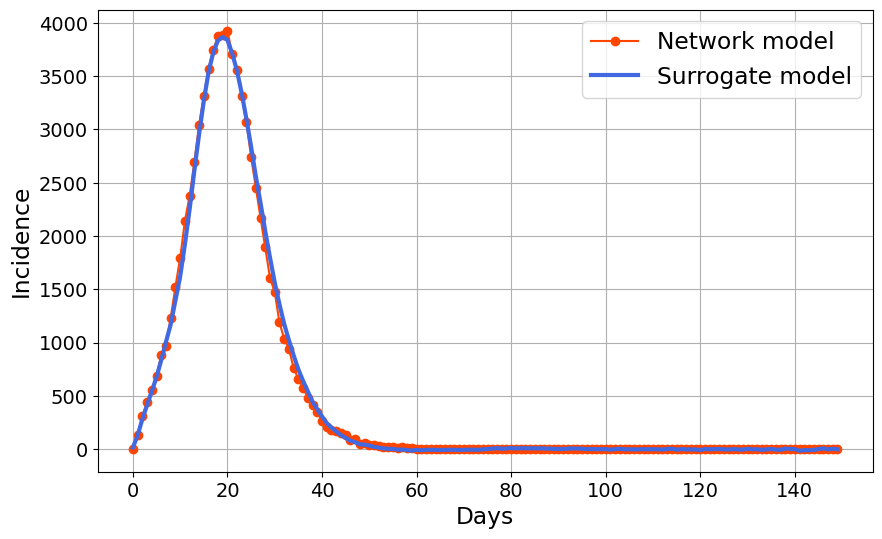

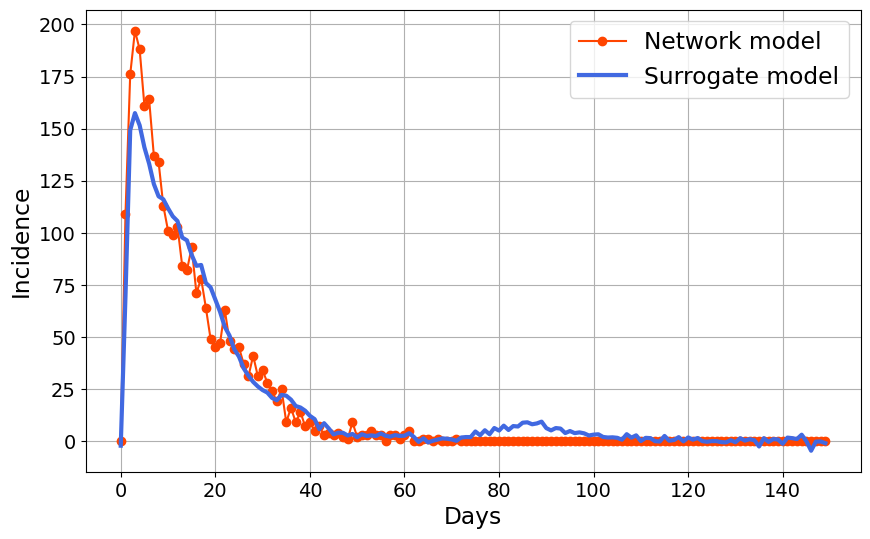

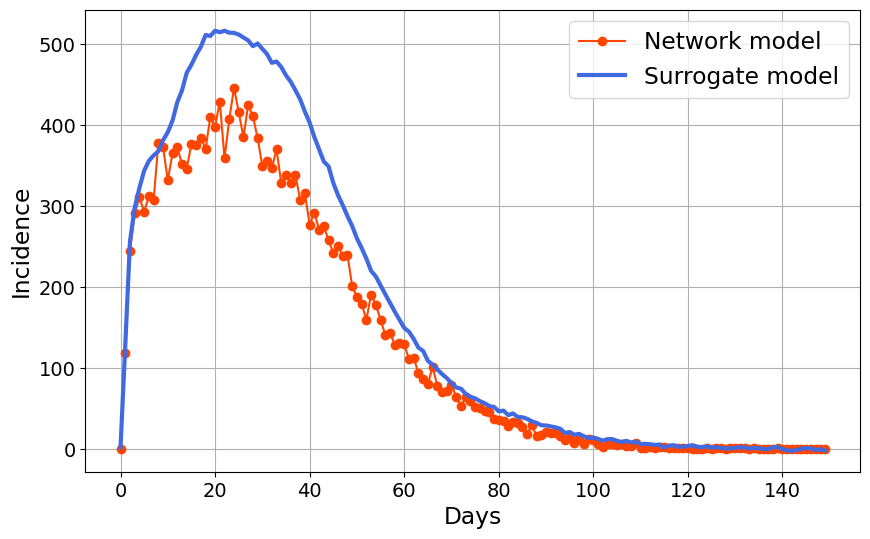

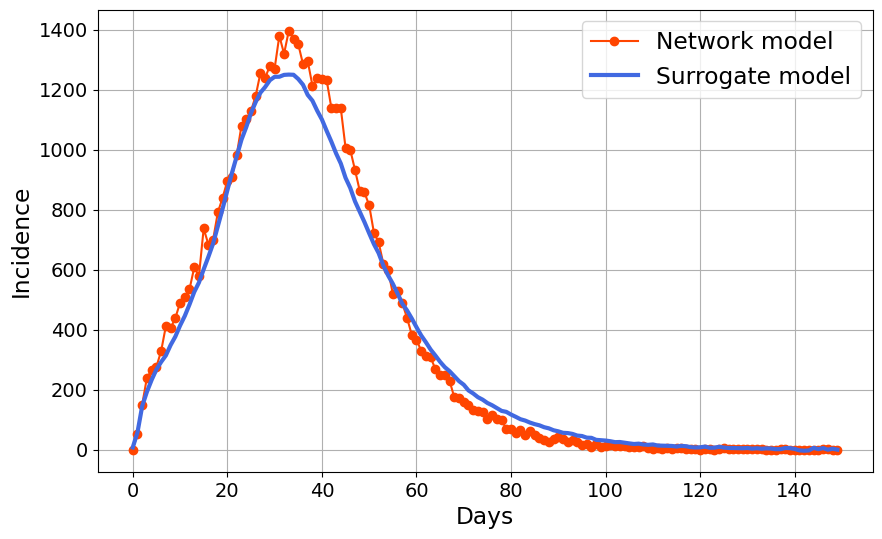

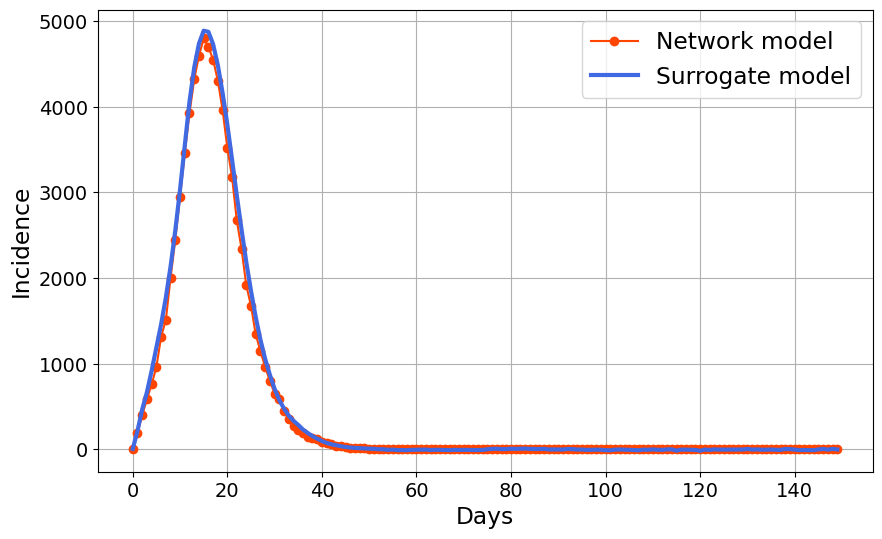

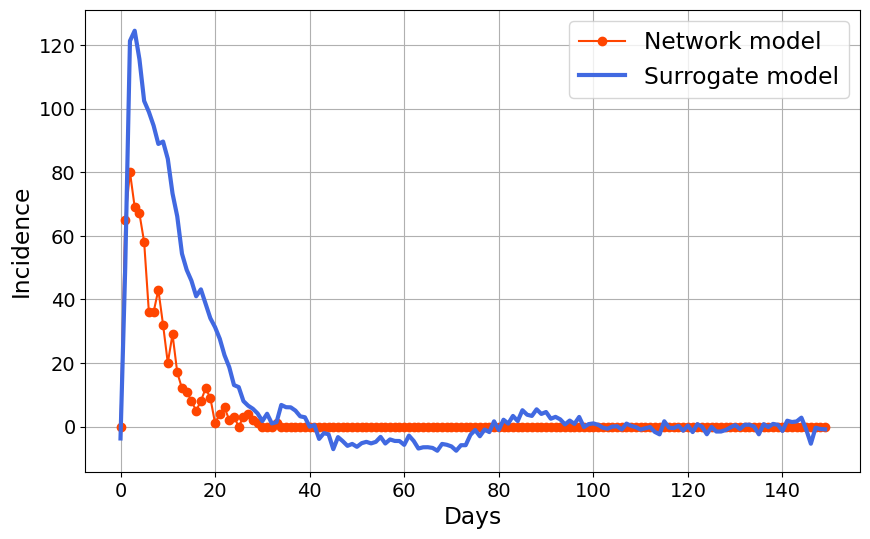

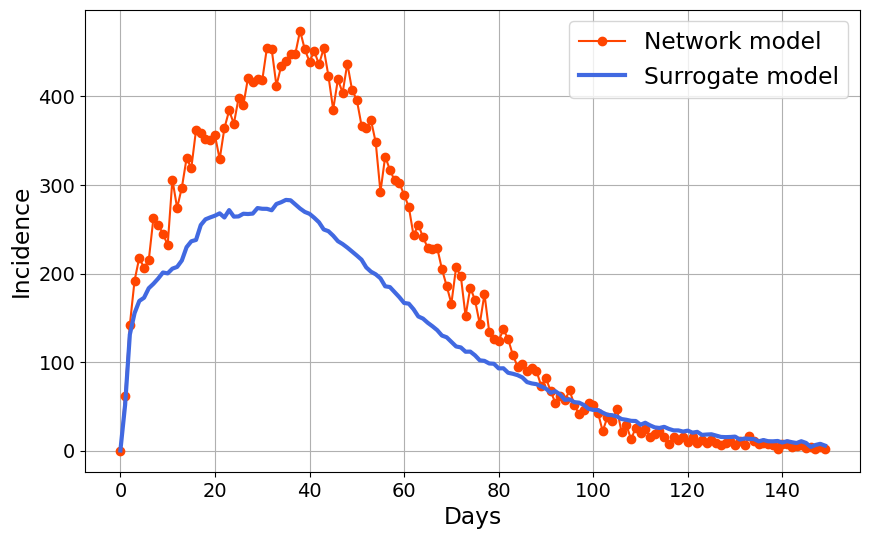

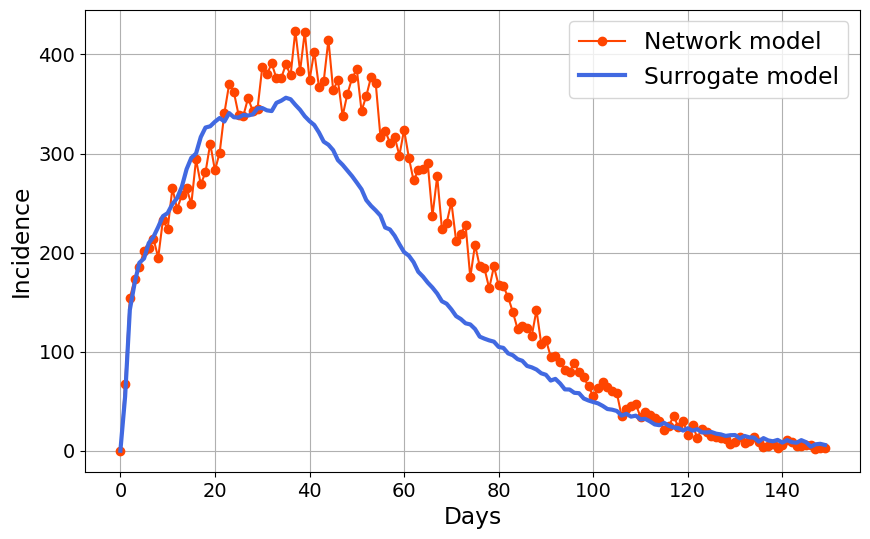

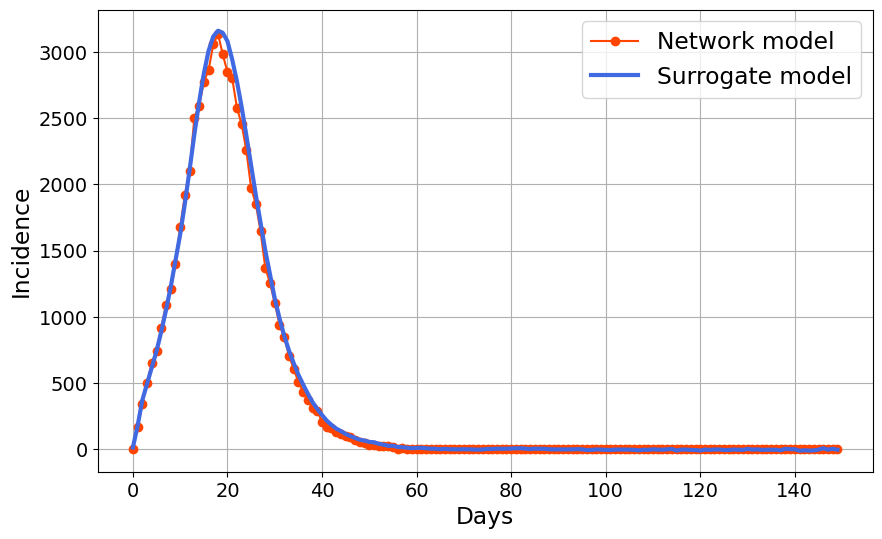

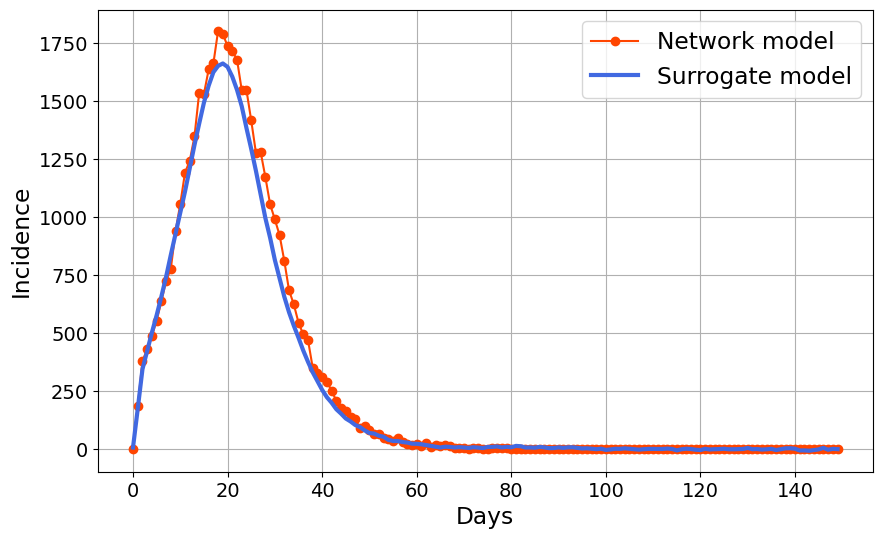

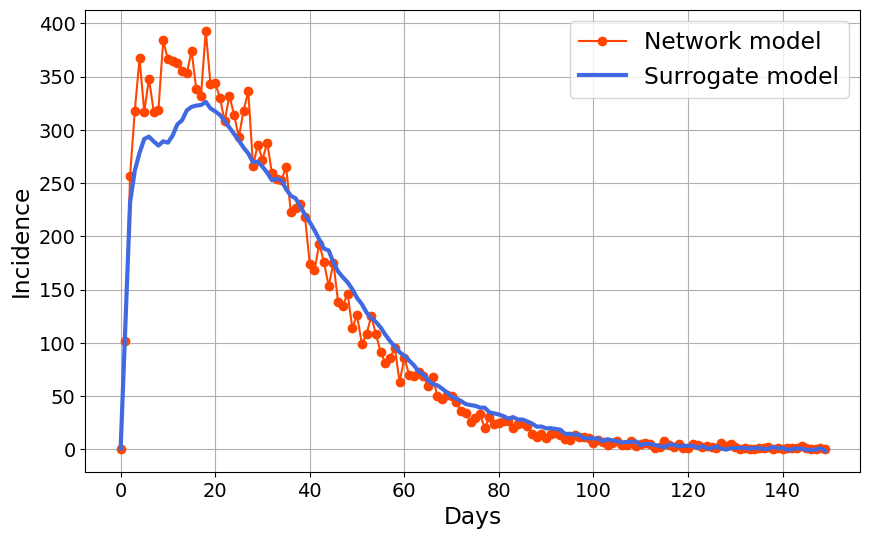

In [26]:
for _ in range(30):
    index = random.randint(0, len(y_test))
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'../figures/surrogate_network_model_comparison_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')

In [21]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(vae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

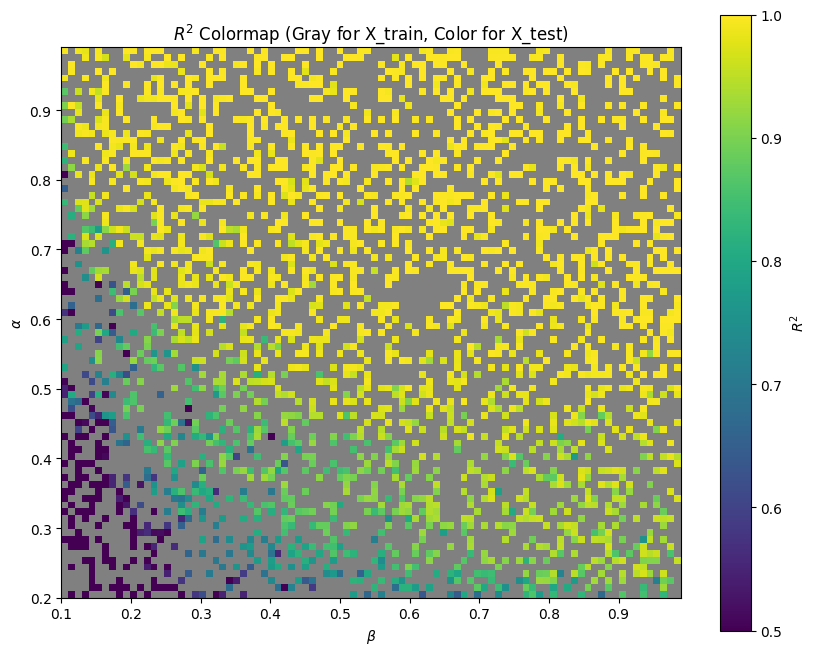

In [22]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis.copy()
cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=cmap, vmin=0.5, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')

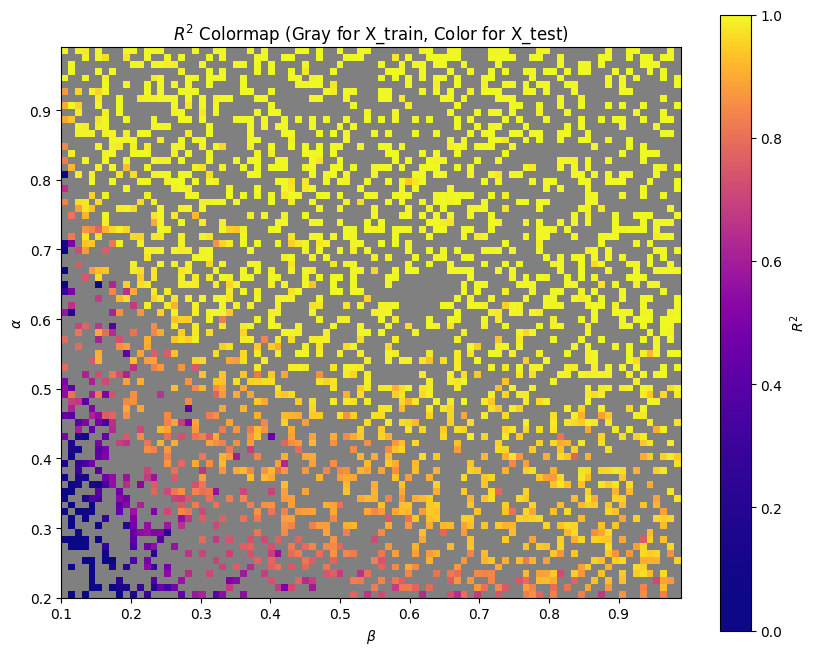

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**2

# Get plasma colormap and create nonlinear version
plasma = plt.cm.plasma
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
plt.figure(figsize=(10, 8))
nonlinear_cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')